# Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import graphviz #dontesi fa plottolasara
from sklearn import tree
from sklearn.model_selection import train_test_split

import warnings

%matplotlib inline

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('XXXXX')

In [4]:
df.shape

(50000, 21)

# Baseline model and metrics

In [5]:
from sklearn.dummy import DummyClassifier

In [6]:
train, test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=432, 
                               stratify=df.TARGET_LABEL_BAD)

In [7]:
features = ['MONTHS_IN_RESIDENCE', 'Sex', 'MONTHS_IN_THE_JOB', 'PERSONAL_NET_INCOME'] #random valtozok a dummy classifiernek

X_train = train.loc[:, features] #X features
y_train = train.TARGET_LABEL_BAD #y a pred

X_test = test.loc[:, features]
y_test = test.TARGET_LABEL_BAD

In [8]:
for strat in ["stratified", "most_frequent", "uniform"]: #stratified a cv eloszlasanak megfelelo valseggel fog 0-1-et valasztani
    cl = DummyClassifier(strategy=strat, random_state=1123)
    cl.fit(X_train, y_train)
    y_pred = pd.Series(cl.predict(X_test), index=y_test.index)
    y_pred_proba = pd.Series(cl.predict_proba(X_test)[:, 1], index=y_test.index) #egyes valtozohoz tartozo konfidenciaertek lesz
    print(strat)
    cf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(cf_mat)
    print(
        "{:.4f} {:.4f} {:4f} {:.4f} {:4f} {:4f}".format(
            y_pred.mean(), 
            metrics.accuracy_score(y_test, y_pred),
            metrics.precision_score(y_test, y_pred),
            metrics.recall_score(y_test, y_pred),
            metrics.f1_score(y_test, y_pred), #ez az elso negy josagmetrika 0-1 erteket vehet fel
            metrics.roc_auc_score(y_test, y_pred_proba) #0.5-1-et vehet fel
        )
    )

stratified
[[8044 1988]
 [1969  499]]
0.1990 0.6834 0.200643 0.2022 0.201413 0.502011
most_frequent
[[10032     0]
 [ 2468     0]]
0.0000 0.8026 0.000000 0.0000 0.000000 0.500000
uniform
[[5088 4944]
 [1214 1254]]
0.4958 0.5074 0.202323 0.5081 0.289407 0.500000


In [12]:
pd.DataFrame(cf_mat)

,0,1
0,5088,4944
1,1214,1254


In [13]:
tn = cf_mat[0,0]
tp = cf_mat[1,1]
fn = cf_mat[1,0]
fp = cf_mat[0,1]

print('True positives', tp)
print('True negatives', tn)
print('False positives', fp)
print('False negatives',fn)

True positives 1254
True negatives 5088
False positives 4944
False negatives 1214


In [14]:
precision = tp / (tp + fp) # best: 1 worst: 0
recall = tp / (tp + fn)  # best: 1 worst: 0
f1_score = 2 * (precision * recall) / (precision + recall) # best: 1 worst: 0
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

Precision: 0.202323330106
Recall: 0.508103727715
F1 score: 0.289406877452


# Decision Tree

The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

- http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- http://scikit-learn.org/stable/modules/tree.html#tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
? DecisionTreeClassifier

In [17]:
train, test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=432, 
                               stratify=df.TARGET_LABEL_BAD)

In [18]:
features = ['MONTHS_IN_RESIDENCE', 'Sex', 'MONTHS_IN_THE_JOB', 'PERSONAL_NET_INCOME']

X_train = train.loc[:, features]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features]
y_test = test.TARGET_LABEL_BAD

In [246]:
? DecisionTreeClassifier

In [19]:
dt = DecisionTreeClassifier(max_depth=3, 
                            class_weight="balanced", #0-1 eloszlasa a 0 fele nehez, ez az eloszlasbeli kulonbseget probalja kiegyensulyozni sulyozassal
                            criterion='entropy') #ez alapjan a josagkriterium alapjan probal vagni (entropiat akar csokkenteni)
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)

#a class weighttel mokoltunk oran

In [20]:
print('{0}, {1}'.format(X_train.shape,X_test.shape))

(37500, 4), (12500, 4)


In [21]:
#lehet-e concatenalni:
q = pd.concat((y_pred_proba,y_pred),axis=1)

In [22]:
q.columns = ['predicted_confidence','predicted_target']

In [23]:
q.head()

,predicted_confidence,predicted_target
13574,0.400057,0
12976,0.458262,0
24391,0.369350,0
45074,0.618559,1
23401,0.522431,1


In [24]:
y_pred.value_counts()

1    7848
0    4652
dtype: int64

In [25]:
y_pred.mean()

0.62783999999999995

In [26]:
def score_classifier(y_test, y_pred, y_pred_proba):
    print(
        #"{:13s} {:.4f} {:.4f} {:4f} {:.4f} {:4f} {}".format(
         #   'DecisionTree',
        "{:.4f} {:.4f} {:4f} {:.4f} {:.4f} {:4f} {}".format(
            y_pred.mean(), 
            metrics.accuracy_score(y_test, y_pred),
            metrics.precision_score(y_test, y_pred),
            metrics.recall_score(y_test, y_pred),
            metrics.f1_score(y_test,y_pred),
            metrics.roc_auc_score(y_test, y_pred_proba),
            y_pred.unique()
        )
    )    

In [27]:
metrics.confusion_matrix(y_test, y_pred)

array([[3992, 6040],
       [ 660, 1808]])

In [28]:
score_classifier(y_test, y_pred, y_pred_proba)

0.6278 0.4640 0.230377 0.7326 0.3505 0.589234 [0 1]


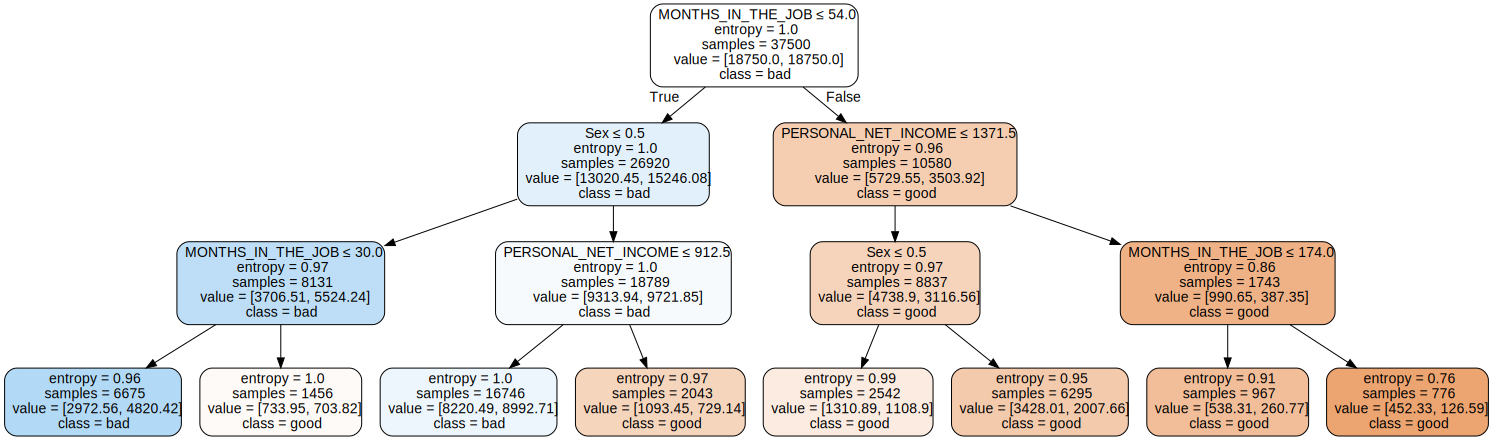

In [29]:
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=features,  
    class_names=['good', 'bad'],#nullas adta vissza a kolcsont, az egyes meg nem
    filled=True, rounded=True,  
    special_characters=True,
    leaves_parallel=True, 
    precision=2
)
graph = graphviz.Source(dot_data) 
graph

In [30]:
dt = DecisionTreeClassifier(max_depth=10, 
                            class_weight="balanced", 
                            criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)

In [31]:
score_classifier(y_test, y_pred, y_pred_proba) #az atirt orai jobbat ad vissza

0.5578 0.5090 0.236804 0.6690 0.3498 0.592819 [0 1]


# Feature importance 
minel tobbszor van hasznalva egy faban a dontesekhez egy valtozo, annal fontosab

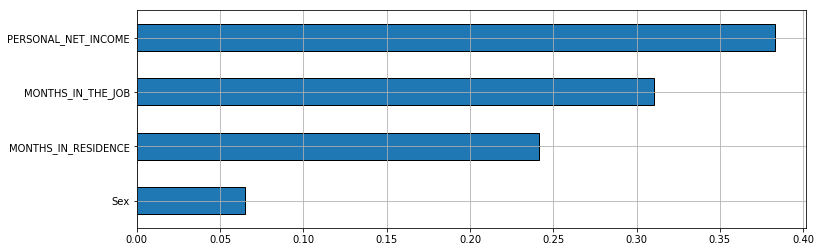

In [32]:
fi = pd.Series(
    dt.feature_importances_, 
    index=features
)
fi
fi.sort_values().plot(kind='barh', grid=True, figsize=(12, 4))

In [33]:
y_pred_proba.value_counts() #minel tobb konfidenciat prediktal, annal jobb, 'risk' szerinti sorrendbe rendezhetoseg miatt

0.572667    1232
0.561959     603
0.000000     602
0.300836     549
0.343015     532
0.520730     522
0.514137     338
0.570574     287
0.466042     277
0.504344     271
0.473120     270
0.504667     261
0.496292     252
0.556326     247
0.530496     233
0.735137     217
0.515560     210
0.507547     208
0.562768     184
0.628949     184
0.652127     180
0.658249     176
0.424112     166
0.329771     164
0.479047     147
0.378457     131
0.573346     129
0.490706     128
0.400398     125
0.419321     124
            ... 
0.135163       9
0.084544       9
0.311056       9
0.726034       8
0.390838       7
0.703295       6
0.844187       6
0.960600       6
0.670155       6
0.503935       5
0.643619       5
0.752940       5
0.619103       5
0.559439       5
0.589181       4
0.871340       4
0.238138       4
0.488781       4
0.603772       3
0.680356       3
0.252963       3
0.890434       3
0.698975       3
0.432431       3
0.448334       2
0.743752       2
0.730384       2
0.904593      

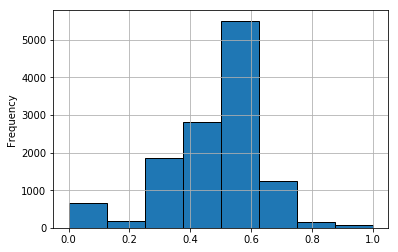

In [262]:
y_pred_proba.plot(kind='hist', bins=8, grid=True)

# Excercise
- építs egy modellt az összes felhasználható feature segítségével, adott magasságú fához
- értékeld ki a modellt az előzőkben készített modellhez és a dummy modellekhez képest. Melyik jóságmértéknél milyen irányú változást tapasztaltál?
- értékeld a hozzáadott feature-t feature importance alapján. 
- Hagyj el egy feature-t amelynek magas a feature importance és nézd meg hogy változnak a jóságmértékek. 
- Hagyj el egy feature-t amelynek alacsony a feature importance és nézd meg hogy változnak a jóságmértékek. 

In [34]:
features = list(df.columns[1:])
features.remove('TARGET_LABEL_BAD')

In [35]:
X_train = train.loc[:, features]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features]
y_test = test.TARGET_LABEL_BAD

In [36]:
cl = DummyClassifier(strategy="uniform", random_state=1123)
cl.fit(X_train, y_train)
y_pred = pd.Series(cl.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(cl.predict_proba(X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_proba)

0.4958 0.5074 0.202323 0.5081 0.2894 0.500000 [0 1]


In [37]:
dt = DecisionTreeClassifier(max_depth=10, 
                            class_weight="balanced", 
                            criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_proba)

0.4302 0.6021 0.267014 0.5818 0.3660 0.623322 [1 0]


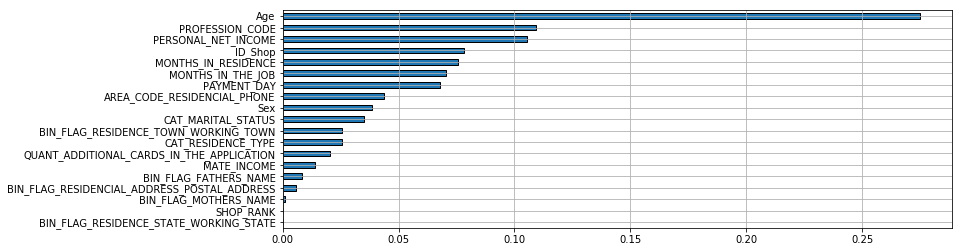

In [38]:
fi = pd.Series(
    dt.feature_importances_, 
    index=features
)
fi.sort_values(inplace=True)
fi.plot(kind='barh', grid=True, figsize=(12, 4))

In [39]:
fi

BIN_FLAG_RESIDENCE_STATE_WORKING_STATE         0.000000
SHOP_RANK                                      0.000000
BIN_FLAG_MOTHERS_NAME                          0.000940
BIN_FLAG_RESIDENCIAL_ADDRESS_POSTAL_ADDRESS    0.005604
BIN_FLAG_FATHERS_NAME                          0.008543
MATE_INCOME                                    0.013818
QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION      0.020401
CAT_RESIDENCE_TYPE                             0.025543
BIN_FLAG_RESIDENCE_TOWN_WORKING_TOWN           0.025696
CAT_MARITAL_STATUS                             0.035184
Sex                                            0.038652
AREA_CODE_RESIDENCIAL_PHONE                    0.043604
PAYMENT_DAY                                    0.067682
MONTHS_IN_THE_JOB                              0.070656
MONTHS_IN_RESIDENCE                            0.075588
ID_Shop                                        0.078163
PERSONAL_NET_INCOME                            0.105547
PROFESSION_CODE                                0

In [40]:
features_without_age = features.copy()
features_without_age.remove('Age')

features_without_mate_income = features.copy()
features_without_mate_income.remove('MATE_INCOME')

In [41]:
X_train = train.loc[:, features_without_age]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features_without_age]
y_test = test.TARGET_LABEL_BAD

dt = DecisionTreeClassifier(max_depth=10, 
                            class_weight="balanced", 
                            criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_proba)

0.4934 0.5627 0.256971 0.6422 0.3671 0.619397 [1 0]


meg kell nezni, hogy magas FI-ju valtozok elhagyasaval kulonbozo metrikak nonek-e, mert csak overfittinget okoznak, ha benne hagyjuk oket

In [42]:
X_train = train.loc[:, features_without_mate_income]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features_without_mate_income]
y_test = test.TARGET_LABEL_BAD

dt = DecisionTreeClassifier(max_depth=10, 
                            class_weight="balanced", 
                            criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_proba)

0.4601 0.5846 0.263085 0.6130 0.3682 0.623590 [1 0]


# Szelekciós stratégiák

- Forward selection: bevett változók halmazát növeljük, amíg a megadott jóságkritérium(ok) növekednek
- Backward elimination: elhagyunk változókat a teljes halmazból, amíg a megadott jóságkritérium(ok) növekednek

# KNN

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these.

http://scikit-learn.org/stable/modules/neighbors.html#neighbors

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
df[['MONTHS_IN_RESIDENCE', 'MONTHS_IN_THE_JOB']].describe(percentiles=[0.75, 0.9, 0.99])

,MONTHS_IN_RESIDENCE,MONTHS_IN_THE_JOB
count,50000.000000,50000.000000
mean,153.288000,50.600400
std,136.498105,73.890169
min,0.000000,0.000000
50%,120.000000,24.000000
75%,240.000000,60.000000
90%,360.000000,144.000000
99%,564.000000,336.000000
max,1188.000000,1176.000000


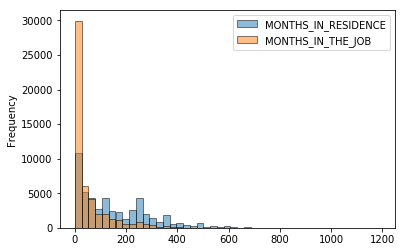

In [45]:
df[['MONTHS_IN_RESIDENCE', 'MONTHS_IN_THE_JOB']].plot(kind='hist', bins=45, alpha=0.5)

In [46]:
df['LOG_MONTHS_IN_RESIDENCE'] = np.log(df['MONTHS_IN_RESIDENCE'] + 1)
df['LOG_MONTHS_IN_THE_JOB'] = np.log(df['MONTHS_IN_THE_JOB'] + 1)

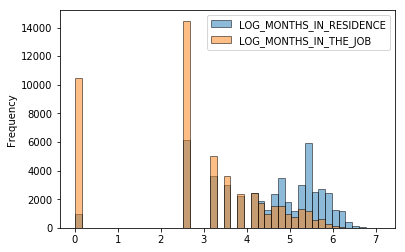

In [47]:
df[['LOG_MONTHS_IN_RESIDENCE', 'LOG_MONTHS_IN_THE_JOB']].plot(kind='hist', bins=45, alpha=0.5)

In [48]:
df.PERSONAL_NET_INCOME.describe(percentiles=[0.99,0.999, 0.9999])

count     5.000000e+04
mean      8.432965e+03
std       4.487915e+05
min       0.000000e+00
50%       4.000000e+02
99%       3.418040e+03
99.9%     8.231269e+03
99.99%    2.557041e+07
max       3.852910e+07
Name: PERSONAL_NET_INCOME, dtype: float64

ha nem csinalunk standard scalet, akkor a surubb valtozo fogja dominalni a knn-t

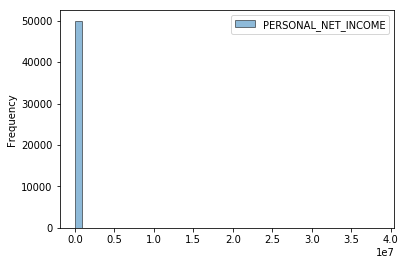

In [49]:
df[['PERSONAL_NET_INCOME']].plot(kind='hist', bins=45, alpha=0.5)

In [50]:
df['LOG_CLIPPED_PERSONAL_NET_INCOME'] = np.log(df.PERSONAL_NET_INCOME.clip(0, 10000) + 1) #logit trafo es kiugro ertekek levagasa

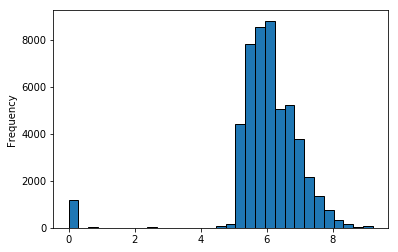

In [51]:
df['LOG_CLIPPED_PERSONAL_NET_INCOME'].plot(kind='hist', bins=31)

In [52]:
train, test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=432, 
                               stratify=df.TARGET_LABEL_BAD)

In [53]:
features = ['LOG_MONTHS_IN_RESIDENCE', 'LOG_MONTHS_IN_THE_JOB', 'LOG_CLIPPED_PERSONAL_NET_INCOME']

X_train = train.loc[:, features]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features]
y_test = test.TARGET_LABEL_BAD

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
#az eddig megismert mintahalmaz mert szorasaval felepitett modelt alkalmazzuk majd a bejovo adathalmazra, tehat a taniton
#nezzuk meg a szorast, meg a kulonbozo tulajdonsagokat
sc = StandardScaler()
sc = sc.fit(X_train)
scaled_X_train = pd.DataFrame(sc.transform(X_train), index=X_train.index)
scaled_X_train.columns = features
scaled_X_test = pd.DataFrame(sc.transform(X_test), index=X_test.index)
scaled_X_test.columns = features

In [56]:
scaled_X_train.describe().T #sikeres a skalazas -> atlag 0 koruli, szorasa kb 1

,count,mean,std,min,25%,50%,75%,max
LOG_MONTHS_IN_RESIDENCE,37500.0,-4.100305e-16,1.000013,-3.523347,-0.682872,0.249191,0.791187,2.038733
LOG_MONTHS_IN_THE_JOB,37500.0,4.926430e-18,1.000013,-1.658504,-0.174440,0.203918,0.720022,2.396050
LOG_CLIPPED_PERSONAL_NET_INCOME,37500.0,2.540901e-16,1.000013,-5.167594,-0.363574,-0.023288,0.502471,2.730693


In [57]:
scaled_X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
LOG_MONTHS_IN_RESIDENCE,12500.0,-0.011852,1.012262,-3.523347,-0.682872,0.249191,0.791187,2.046713
LOG_MONTHS_IN_THE_JOB,12500.0,-0.010099,1.001471,-1.658504,-0.174440,-0.174440,0.720022,2.432573
LOG_CLIPPED_PERSONAL_NET_INCOME,12500.0,-0.020266,1.034468,-5.167594,-0.366744,-0.027555,0.490867,2.730693


In [58]:
knn = KNeighborsClassifier(n_neighbors=1, p=2)
nb = knn.fit(scaled_X_train, y_train)
y_pred = pd.Series(knn.predict(scaled_X_test), index=y_test.index)
y_pred_prob = pd.Series(knn.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.1959 0.6900 0.212740 0.2111 0.2119 0.509459 [0 1]
0.0    10051
1.0     2449
dtype: int64


In [59]:
knn = KNeighborsClassifier(n_neighbors=3, p=2)
nb = knn.fit(scaled_X_train, y_train)
y_pred = pd.Series(knn.predict(scaled_X_test), index=y_test.index)
y_pred_prob = pd.Series(knn.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.1152 0.7422 0.238194 0.1390 0.1755 0.522181 [0 1]
0.000000    6491
0.333333    4569
0.666667    1288
1.000000     152
dtype: int64


In [60]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
nb = knn.fit(scaled_X_train, y_train)
y_pred = pd.Series(knn.predict(scaled_X_test), index=y_test.index)
y_pred_prob = pd.Series(knn.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.0722 0.7607 0.210410 0.0770 0.1127 0.530780 [0 1]
0.2    4703
0.0    4383
0.4    2511
0.6     754
0.8     139
1.0      10
dtype: int64


In [61]:
knn = KNeighborsClassifier(n_neighbors=11, p=2)
nb = knn.fit(scaled_X_train, y_train)
y_pred = pd.Series(knn.predict(scaled_X_test), index=y_test.index)
y_pred_prob = pd.Series(knn.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.0245 0.7910 0.264706 0.0328 0.0584 0.543114 [0 1]
0.181818    3145
0.090909    3036
0.272727    2398
0.000000    1508
0.363636    1442
0.454545     665
0.545455     253
0.636364      38
0.818182       8
0.727273       7
dtype: int64


In [62]:
knn = KNeighborsClassifier(n_neighbors=21, p=2)
nb = knn.fit(scaled_X_train, y_train)
y_pred = pd.Series(knn.predict(scaled_X_test), index=y_test.index)
y_pred_prob = pd.Series(knn.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.0044 0.8007 0.290909 0.0065 0.0127 0.555493 [0 1]
0.190476    2131
0.142857    2064
0.095238    1799
0.238095    1715
0.285714    1415
0.047619    1080
0.333333     926
0.380952     576
0.000000     300
0.428571     270
0.476190     169
0.523810      37
0.571429      18
dtype: int64


# Naive bayes

http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

In [63]:
 from sklearn.naive_bayes import BernoulliNB, GaussianNB #bernoulli az a binaris kategorikus valtozokat eszi meg, a gaussi meg a
    #gaussi eloszlassal rendelkezo folytonosokat.
    #Bernoulli az gyorsabb, nagyobb adathalmazokon is tud dolgozni, rengeteg feature-vel

In [64]:
? BernoulliNB

In [65]:
? pd.Categorical

In [66]:
? pd.get_dummies

In [67]:
df.columns

Index(['ID_Client', 'ID_Shop', 'Sex', 'Age', 'AREA_CODE_RESIDENCIAL_PHONE',
       'PAYMENT_DAY', 'SHOP_RANK', 'MONTHS_IN_RESIDENCE', 'MONTHS_IN_THE_JOB',
       'PROFESSION_CODE', 'MATE_INCOME', 'PERSONAL_NET_INCOME',
       'QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION', 'TARGET_LABEL_BAD',
       'BIN_FLAG_MOTHERS_NAME', 'BIN_FLAG_FATHERS_NAME',
       'BIN_FLAG_RESIDENCE_TOWN_WORKING_TOWN',
       'BIN_FLAG_RESIDENCE_STATE_WORKING_STATE',
       'BIN_FLAG_RESIDENCIAL_ADDRESS_POSTAL_ADDRESS', 'CAT_MARITAL_STATUS',
       'CAT_RESIDENCE_TYPE', 'LOG_MONTHS_IN_RESIDENCE',
       'LOG_MONTHS_IN_THE_JOB', 'LOG_CLIPPED_PERSONAL_NET_INCOME'],
      dtype='object')

In [68]:
categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 'CAT_MARITAL_STATUS', #oran itt is kivagtunk belole a CAT_ kezdetueket
    'CAT_RESIDENCE_TYPE', 'AREA_CODE_RESIDENCIAL_PHONE',
]
df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))

In [69]:
cat_train, cat_test = train_test_split(df_cats, train_size=0.75, test_size=0.25, random_state=432, stratify=df.TARGET_LABEL_BAD)

In [70]:
df_cats.shape

(50000, 402)

In [71]:
(cat_train.index == train.index).all(), (cat_test.index == test.index).all()

(True, True)

In [72]:
X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

In [302]:
nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.0354 0.7963 0.411765 0.0737 0.1251 0.629769 [0 1]
0.253861    65
0.217818    63
0.124703    51
0.308382    50
0.081708    46
0.098052    44
0.257189    40
0.118001    37
0.280503    37
0.111115    35
0.099610    34
0.281210    33
0.171911    32
0.306378    31
0.193191    30
0.185823    30
0.376068    28
0.178431    27
0.110770    27
0.097151    27
0.091065    26
0.156703    25
0.029580    24
0.292116    24
0.428377    23
0.393838    23
0.287711    23
0.249193    23
0.031489    23
0.580256    22
            ..
0.170645     1
0.517395     1
0.251786     1
0.044440     1
0.085947     1
0.613225     1
0.321196     1
0.243551     1
0.201017     1
0.130869     1
0.049548     1
0.186851     1
0.215959     1
0.436799     1
0.472975     1
0.092550     1
0.210533     1
0.031359     1
0.053410     1
0.171494     1
0.334825     1
0.143468     1
0.357304     1
0.078650     1
0.262835     1
0.482633     1
0.211159     1
0.067338     1
0.049390     1
0.160206     1
Length: 6406, dtype: int64


# Mi legyen a folytonos változókkal? Binnelés

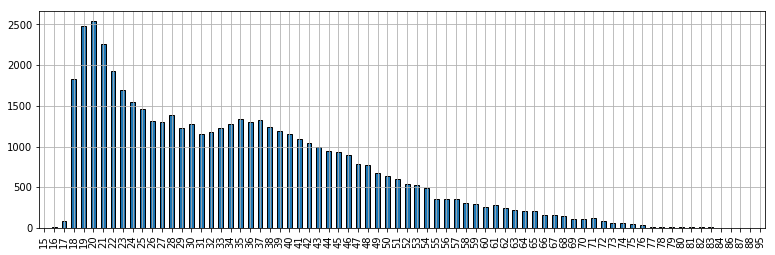

In [73]:
df['Age'].value_counts().sort_index().plot(kind='bar', figsize=(13, 4), grid=True)

In [74]:
? pd.cut

In [75]:
pd.cut(df['Age'], bins=5)

0         (31.0, 47.0]
1        (14.92, 31.0]
2        (14.92, 31.0]
3         (31.0, 47.0]
4        (14.92, 31.0]
5        (14.92, 31.0]
6        (14.92, 31.0]
7        (14.92, 31.0]
8        (14.92, 31.0]
9         (47.0, 63.0]
10        (47.0, 63.0]
11        (31.0, 47.0]
12       (14.92, 31.0]
13        (31.0, 47.0]
14       (14.92, 31.0]
15        (47.0, 63.0]
16       (14.92, 31.0]
17        (31.0, 47.0]
18        (31.0, 47.0]
19       (14.92, 31.0]
20       (14.92, 31.0]
21       (14.92, 31.0]
22       (14.92, 31.0]
23        (31.0, 47.0]
24        (31.0, 47.0]
25       (14.92, 31.0]
26        (63.0, 79.0]
27        (63.0, 79.0]
28        (31.0, 47.0]
29        (31.0, 47.0]
             ...      
49970    (14.92, 31.0]
49971    (14.92, 31.0]
49972     (31.0, 47.0]
49973    (14.92, 31.0]
49974     (31.0, 47.0]
49975     (31.0, 47.0]
49976    (14.92, 31.0]
49977     (31.0, 47.0]
49978    (14.92, 31.0]
49979    (14.92, 31.0]
49980    (14.92, 31.0]
49981    (14.92, 31.0]
49982     (

In [85]:
? pd.qcut

In [77]:
pd.qcut(df['Age'], q=10)

0          (41.0, 46.0]
1        (14.999, 20.0]
2          (20.0, 22.0]
3          (46.0, 53.0]
4          (25.0, 29.0]
5          (25.0, 29.0]
6          (20.0, 22.0]
7          (20.0, 22.0]
8          (25.0, 29.0]
9          (53.0, 95.0]
10         (46.0, 53.0]
11         (29.0, 33.0]
12         (20.0, 22.0]
13         (33.0, 37.0]
14         (25.0, 29.0]
15         (46.0, 53.0]
16       (14.999, 20.0]
17         (41.0, 46.0]
18         (41.0, 46.0]
19       (14.999, 20.0]
20         (25.0, 29.0]
21       (14.999, 20.0]
22       (14.999, 20.0]
23         (41.0, 46.0]
24         (37.0, 41.0]
25       (14.999, 20.0]
26         (53.0, 95.0]
27         (53.0, 95.0]
28         (29.0, 33.0]
29         (41.0, 46.0]
              ...      
49970    (14.999, 20.0]
49971      (29.0, 33.0]
49972      (37.0, 41.0]
49973      (25.0, 29.0]
49974      (29.0, 33.0]
49975      (41.0, 46.0]
49976      (20.0, 22.0]
49977      (37.0, 41.0]
49978      (22.0, 25.0]
49979      (25.0, 29.0]
49980      (25.0

In [78]:
df.Age.describe()

count    50000.000000
mean        34.684240
std         13.076314
min         15.000000
25%         23.000000
50%         33.000000
75%         43.000000
max         95.000000
Name: Age, dtype: float64

In [79]:
def cut_age(x):
    if x < 18:
        return 'age < 18'
    elif x < 23:
        return '18 <= age < 23'
    elif x < 36:
        return '23 <= age < 36'
    elif x < 51:
        return '36 <= age < 51'
    elif x < 65:
        return '51 <= age < 65'
    else:
        return '65 <= age'

In [80]:
df['cat_Age'] = df['Age'].map(cut_age)

In [81]:
categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 'CAT_MARITAL_STATUS', 
    'CAT_RESIDENCE_TYPE', 'AREA_CODE_RESIDENCIAL_PHONE', 
    'cat_Age'
]
df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))
print(df_cats.shape)

(50000, 408)


In [82]:
cat_train, cat_test = train_test_split(
    df_cats, train_size=0.75, test_size=0.25, 
    random_state=432, stratify=df.TARGET_LABEL_BAD)

In [83]:
X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

In [84]:
nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)
print(y_pred_prob.value_counts())

0.1017 0.7742 0.360346 0.1856 0.2450 0.644334 [0 1]
0.362634    26
0.049308    26
0.141290    25
0.282091    22
0.059592    21
0.339913    21
0.243348    21
0.476711    21
0.318015    20
0.165499    19
0.410076    19
0.310463    19
0.093185    18
0.076678    18
0.055178    17
0.072343    16
0.011967    16
0.060580    15
0.414315    15
0.285647    15
0.139654    15
0.067917    15
0.112370    15
0.444235    15
0.059021    15
0.551864    15
0.126155    15
0.337804    15
0.576678    14
0.111546    13
            ..
0.078311     1
0.571149     1
0.160358     1
0.071477     1
0.295494     1
0.374629     1
0.505579     1
0.501129     1
0.477705     1
0.092004     1
0.807839     1
0.019624     1
0.051304     1
0.230258     1
0.266720     1
0.208098     1
0.112027     1
0.247276     1
0.351239     1
0.162362     1
0.693336     1
0.648446     1
0.148531     1
0.323258     1
0.244937     1
0.273503     1
0.051449     1
0.086832     1
0.383663     1
0.206586     1
Length: 8329, dtype: int64


# Homework
Az órákon tanult módszerekkel nézz meg több feature halmazt az egyes osztályozókra:
1. DT
- Csökkentsd 1-3 változóval a legbővebb feature halmazt (hagyj el a feature importance alapján relevnás, közepesen releváns és irreleváns feature-öket.)
- Optimalizáld a max_depth komplexitás paramétert, a kialakított legjobb feature halmazon. Legyen az optimalizálandó jóságkritérium a metrics.roc_auc_score.
2. KNN
- Válassz még egy folytonos változót, amelyet transzformálj a fenti módszerekkel és add hozzá a modellhez.
- Ha ez a változó növelte a modell hatékonyságát a metrics.roc_auc_score tekintetében, akkor tartsd meg és optimalizáld szintén ezen a jóságkritériumon az n_neighbours paramétert. (1 <= n_neighbours <= 21, csak páratlan szám)
- Nézd meg, hogy a manhatten távolsággal (p=1) jobb vagy rosszabb eredményt kapnál-e
3. NB
- Keress 1 további folytonos változót, amellyel növeled a metrics.roc_auc_score értéket. A modell-be helyezés előtt binneld a változót.
- Keress 1 további kategórikus változót, amellyel növeled a metrics.roc_auc_score értéket.

Az három osztályozó egyes jóságkritériumait foglald össze egy táblázatba. 

# Hint:
- egy jobb score függvény egyszerűsíti az életünket

In [315]:
def score_classifier(y_test, y_pred, y_pred_proba, classifier=None):
    cf_mat = metrics.confusion_matrix(y_test, y_pred)
    tn = cf_mat[0,0]
    tp = cf_mat[1,1]
    fn = cf_mat[1,0]
    fp = cf_mat[0,1]
    scores = pd.Series({
        'mean_prediction': y_pred.mean(), 
        'n_predicted_classes': y_pred.nunique(),
        'confmat_tp': tp,
        'confmat_tn': tn,
        'confmat_fn': fn,
        'confmat_fp': fp,        
        'score_accuracy': metrics.accuracy_score(y_test, y_pred),
        'score_precision': metrics.precision_score(y_test, y_pred),
        'score_recall': metrics.recall_score(y_test, y_pred),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'score_roc_auc': metrics.roc_auc_score(y_test, y_pred_proba),        
    })
    scores.name = classifier
    return scores

In [316]:
nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
nb_scores = score_classifier(y_test, y_pred, y_pred_prob, 'naive_bayes')

In [317]:
dt = DecisionTreeClassifier(max_depth=10, 
                            class_weight="balanced", 
                            criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)
dt_scores = score_classifier(y_test, y_pred, y_pred_proba, 'decision_tree')

# Hint
a pd.concat segítségével a pd.Series-ek összeilleszthetők

In [318]:
pd.concat((nb_scores, dt_scores), axis=1)

,naive_bayes,decision_tree
confmat_fn,2010.000000,1060.000000
confmat_fp,813.000000,3947.000000
confmat_tn,9219.000000,6085.000000
confmat_tp,458.000000,1408.000000
f1_score,0.244985,0.359964
mean_prediction,0.101680,0.428400
n_predicted_classes,2.000000,2.000000
score_accuracy,0.774160,0.599440
score_precision,0.360346,0.262932
score_recall,0.185575,0.570502


# Hint
Paraméterket is megadhatunk a stringben, vagy akár a tanítást is egy külön függvénybe tehetjük

In [319]:
def fit_and_score(param):
    dt = DecisionTreeClassifier(max_depth=param, 
                                class_weight="balanced", 
                                criterion='entropy')
    dt = dt.fit(X_train, y_train)
    y_pred = pd.Series(dt.predict(X_test), index=y_test.index)
    y_pred_proba = pd.Series(dt.predict_proba(X_test)[:, 1], index=y_test.index)
    dt_scores = score_classifier(y_test, y_pred, y_pred_proba, 'decision_tree_max_depth={}'.format(param))
    return dt_scores

results = pd.concat((fit_and_score(5), fit_and_score(10)), axis=1)

# Hint
Lehet plottolni is :)

In [320]:
results

,decision_tree_max_depth=5,decision_tree_max_depth=10
confmat_fn,910.000000,1060.000000
confmat_fp,4438.000000,3948.000000
confmat_tn,5594.000000,6084.000000
confmat_tp,1558.000000,1408.000000
f1_score,0.368147,0.359918
mean_prediction,0.479680,0.428480
n_predicted_classes,2.000000,2.000000
score_accuracy,0.572160,0.599360
score_precision,0.259840,0.262883
score_recall,0.631280,0.570502


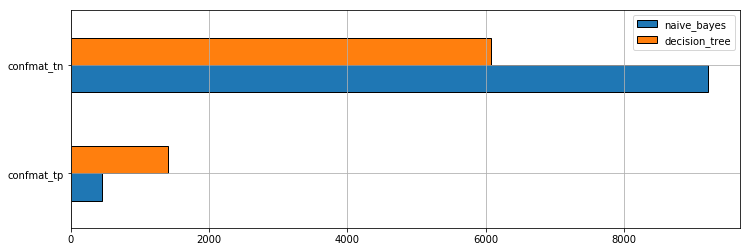

In [321]:
results = pd.concat((nb_scores, dt_scores), axis=1)
results.loc[['confmat_tp', 'confmat_tn'], :].plot(kind='barh', grid=True, figsize=(12,4))

# 1. DT
## 2. Featurehalmaz csokkentese

In [322]:
features = list(df.columns[1:])
features.remove('TARGET_LABEL_BAD')
features.remove('cat_Age')

In [323]:

dt = DecisionTreeClassifier(max_depth=13,class_weight='balanced',
                            criterion='entropy')

train,test = train_test_split(df, train_size = 0.75,test_size=0.25,
                             random_state = 1181,
                              stratify =df.TARGET_LABEL_BAD)
X_test = test.loc[:,features]
y_test = test.TARGET_LABEL_BAD
X_train = train.loc[:,features]
y_train = train.TARGET_LABEL_BAD

alap = fit_and_score(13)
alap2 = fit_and_score(5)

In [324]:
indices = X_train.columns
dt = dt.fit(X_train, y_train)

In [325]:
fi = pd.Series(dt.feature_importances_, X_train.columns)

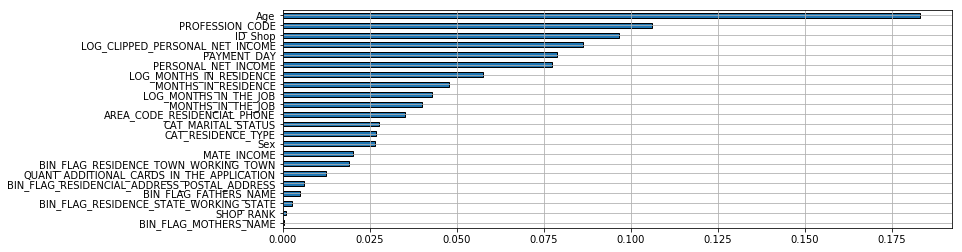

In [326]:
fi.sort_values().plot(kind="barh",grid=True,figsize=(12,4))

In [327]:
rele = 'Age'
kevesberele = 'Sex'
nemrele = 'BIN_FLAG_MOTHERS_NAME'

f2 = features.copy()
f3 = features.copy()
f4 = features.copy()

f2.remove(rele)
f3.remove(kevesberele)
f4.remove(nemrele)



In [328]:
f6 = features.copy()
f6.remove(rele)
f6.remove(kevesberele)

In [329]:
f5 = features.copy()
f5.remove(rele)
f5.remove(kevesberele)
f5.remove(nemrele)


In [330]:
f4

['ID_Shop',
 'Sex',
 'Age',
 'AREA_CODE_RESIDENCIAL_PHONE',
 'PAYMENT_DAY',
 'SHOP_RANK',
 'MONTHS_IN_RESIDENCE',
 'MONTHS_IN_THE_JOB',
 'PROFESSION_CODE',
 'MATE_INCOME',
 'PERSONAL_NET_INCOME',
 'QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION',
 'BIN_FLAG_FATHERS_NAME',
 'BIN_FLAG_RESIDENCE_TOWN_WORKING_TOWN',
 'BIN_FLAG_RESIDENCE_STATE_WORKING_STATE',
 'BIN_FLAG_RESIDENCIAL_ADDRESS_POSTAL_ADDRESS',
 'CAT_MARITAL_STATUS',
 'CAT_RESIDENCE_TYPE',
 'LOG_MONTHS_IN_RESIDENCE',
 'LOG_MONTHS_IN_THE_JOB',
 'LOG_CLIPPED_PERSONAL_NET_INCOME']

In [331]:
def traintestsep(featurelist):
    train,test = train_test_split(df, train_size = 0.75,test_size=0.25,
                             random_state = 1181,
                              stratify =df.TARGET_LABEL_BAD)
    X_test = test.loc[:,featurelist]
    y_test = test.TARGET_LABEL_BAD
    X_train = train.loc[:,featurelist]
    y_train = train.TARGET_LABEL_BAD
    
    return X_test,y_test,X_train,y_train

In [332]:
X_test, y_test,X_train,y_train = traintestsep(f2)
results_1 = fit_and_score(13)
X_test, y_test,X_train,y_train = traintestsep(f3)
results_2 = fit_and_score(13)
X_test, y_test,X_train,y_train = traintestsep(f4)
results_3 = fit_and_score(13)
X_test, y_test,X_train,y_train = traintestsep(f5)
results_4 = fit_and_score(13)
X_test, y_test,X_train,y_train = traintestsep(f6)
results_5 = fit_and_score(13)

results = pd.concat((alap,results_1,results_2,results_3,results_5, results_4),axis=1)

In [333]:
results

,decision_tree_max_depth=13,decision_tree_max_depth=13,decision_tree_max_depth=13,decision_tree_max_depth=13,decision_tree_max_depth=13,decision_tree_max_depth=13
confmat_fn,1041.000000,1043.000000,1092.000000,1090.000000,1042.000000,1044.000000
confmat_fp,4090.000000,4285.000000,3930.000000,3833.000000,4171.000000,4176.000000
confmat_tn,5941.000000,5746.000000,6101.000000,6198.000000,5860.000000,5855.000000
confmat_tp,1428.000000,1426.000000,1377.000000,1379.000000,1427.000000,1425.000000
f1_score,0.357581,0.348655,0.354167,0.359068,0.353787,0.353160
mean_prediction,0.441440,0.456880,0.424560,0.416960,0.447840,0.448080
n_predicted_classes,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
score_accuracy,0.589520,0.573760,0.598240,0.606160,0.582960,0.582400
score_precision,0.258789,0.249694,0.259469,0.264582,0.254912,0.254419
score_recall,0.578372,0.577562,0.557716,0.558526,0.577967,0.577157


a relevans elhagyasaval csokken a roc_auc ertekunk, a kevesbe relevanst elhagyva is csokken, de kisebb mertekben, a nem relevanst elhagyva jobb roc_auc erteket kaptam. az elso kettot egyutt elhagyva csokkent a metrika, mind a harmat elhagyva pedig megint nott

## 3. - optimalis parameter megtalalasa
jelen esetben a legjobb halmaz az az volt, amikor a legkevesbe relevanst hagytam csak el, most ezen dolgozva tovabb:

In [334]:
def parameterFinder():
    best = 0
    depth = 1
    while(depth < 50):
        current = fit_and_score(depth)
        if(current['score_roc_auc'] > best):
            best = current['score_roc_auc']
            bestDepth = depth
        depth = depth+1
    print('A legjobb metrikaval rendelkezo fa melysege: {0}, melyhez tartozo roc_auc-ertek: {1}'.format(bestDepth,best))
    

In [335]:
X_test, y_test,X_train,y_train = traintestsep(f4)

In [336]:
parameterFinder()

A legjobb metrikaval rendelkezo fa melysege: 5, melyhez tartozo roc_auc-ertek: 0.6492032455564342


# 4. KNN
## 5. Válassz még egy folytonos változót, amelyet transzformálj a fenti módszerekkel és add hozzá a modellhez

In [337]:
df.columns[1:]

Index(['ID_Shop', 'Sex', 'Age', 'AREA_CODE_RESIDENCIAL_PHONE', 'PAYMENT_DAY',
       'SHOP_RANK', 'MONTHS_IN_RESIDENCE', 'MONTHS_IN_THE_JOB',
       'PROFESSION_CODE', 'MATE_INCOME', 'PERSONAL_NET_INCOME',
       'QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION', 'TARGET_LABEL_BAD',
       'BIN_FLAG_MOTHERS_NAME', 'BIN_FLAG_FATHERS_NAME',
       'BIN_FLAG_RESIDENCE_TOWN_WORKING_TOWN',
       'BIN_FLAG_RESIDENCE_STATE_WORKING_STATE',
       'BIN_FLAG_RESIDENCIAL_ADDRESS_POSTAL_ADDRESS', 'CAT_MARITAL_STATUS',
       'CAT_RESIDENCE_TYPE', 'LOG_MONTHS_IN_RESIDENCE',
       'LOG_MONTHS_IN_THE_JOB', 'LOG_CLIPPED_PERSONAL_NET_INCOME', 'cat_Age'],
      dtype='object')

In [338]:

features = ['LOG_MONTHS_IN_RESIDENCE','LOG_MONTHS_IN_THE_JOB','LOG_CLIPPED_PERSONAL_NET_INCOME']
? df.clip
df['LOG_CLIPPED_MATE_NET_INCOME'] = np.log(df.PERSONAL_NET_INCOME.clip(1, 10000) + 1)


In [339]:
df.LOG_CLIPPED_PERSONAL_NET_INCOME.describe()

count    50000.000000
mean         6.020186
std          1.176353
min          0.000000
25%          5.602119
50%          5.993961
75%          6.609349
max          9.210440
Name: LOG_CLIPPED_PERSONAL_NET_INCOME, dtype: float64

## 6. Ha ez a változó növelte a modell hatékonyságát a metrics.roc_auc_score tekintetében, akkor tartsd meg és optimalizáld szintén ezen a jóságkritériumon az n_neighbours paramétert. (1 <= n_neighbours <= 21, csak páratlan szám)

In [360]:
features = ['LOG_MONTHS_IN_RESIDENCE', 'LOG_MONTHS_IN_THE_JOB', 'LOG_CLIPPED_PERSONAL_NET_INCOME']
features2 = ['LOG_MONTHS_IN_RESIDENCE','LOG_MONTHS_IN_THE_JOB']

train, test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=432, 
                               stratify=df.TARGET_LABEL_BAD)

X_train = train.loc[:, features2]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features2]
y_test = test.TARGET_LABEL_BAD

sc = StandardScaler()
sc = sc.fit(X_train)

y_train = train.TARGET_LABEL_BAD
y_test = test.TARGET_LABEL_BAD


scaled_X_train = pd.DataFrame(sc.transform(X_train), index=X_train.index)
scaled_X_train.columns = features2

scaled_X_test = pd.DataFrame(sc.transform(X_test), index=X_test.index)
scaled_X_test.columns = features2

def fit_and_score2(param1,param2):
    knn = KNeighborsClassifier(n_neighbors=param1,p=param2)
    dt = knn.fit(scaled_X_train, y_train)
    y_pred = pd.Series(dt.predict(scaled_X_test), index=y_test.index)
    y_pred_proba = pd.Series(dt.predict_proba(scaled_X_test)[:, 1], index=y_test.index)
    dt_scores = score_classifier(y_test, y_pred, y_pred_proba, 'knn_neighNum={}'.format(param1))
    return dt_scores

def parameterFinder():
    best = 0
    neighbors = 1
    while(neighbors < 76):
        current = fit_and_score2(neighbors,2)
        if(current['score_roc_auc'] > best):
            best = current['score_roc_auc']
            bestNeighbors = neighbors
        neighbors = neighbors+2
    print('A legjobb metrikaval rendelkezo knn algo szomszedszama: {0}, melyhez tartozo roc_auc-ertek: {1}'.format(bestNeighbors,best))

In [361]:
fit_and_score2(7,2)

confmat_fn             2430.000000
confmat_fp              141.000000
confmat_tn             9891.000000
confmat_tp               38.000000
f1_score                  0.028712
mean_prediction           0.014320
n_predicted_classes       2.000000
score_accuracy            0.794320
score_precision           0.212291
score_recall              0.015397
score_roc_auc             0.534485
Name: knn_neighNum=7, dtype: float64

In [362]:
X_train = train.loc[:, features]
y_train = train.TARGET_LABEL_BAD

X_test = test.loc[:, features]
y_test = test.TARGET_LABEL_BAD

sc = StandardScaler()
sc = sc.fit(X_train)

y_train = train.TARGET_LABEL_BAD
y_test = test.TARGET_LABEL_BAD


scaled_X_train = pd.DataFrame(sc.transform(X_train), index=X_train.index)
scaled_X_train.columns = features

scaled_X_test = pd.DataFrame(sc.transform(X_test), index=X_test.index)
scaled_X_test.columns = features

In [363]:
fit_and_score2(7,2)

confmat_fn             2333.000000
confmat_fp              483.000000
confmat_tn             9549.000000
confmat_tp              135.000000
f1_score                  0.087492
mean_prediction           0.049440
n_predicted_classes       2.000000
score_accuracy            0.774720
score_precision           0.218447
score_recall              0.054700
score_roc_auc             0.542012
Name: knn_neighNum=7, dtype: float64

latszik, hogy javitott valamennyit azt erteken, igy johet az optimalizalas 0.542012<->0.534485

In [364]:
parameterFinder()

A legjobb metrikaval rendelkezo knn algo szomszedszama: 63, melyhez tartozo roc_auc-ertek: 0.5710175978198775


In [365]:
print(y_pred_prob.value_counts())

0.362634    26
0.049308    26
0.141290    25
0.282091    22
0.059592    21
0.339913    21
0.243348    21
0.476711    21
0.318015    20
0.165499    19
0.410076    19
0.310463    19
0.093185    18
0.076678    18
0.055178    17
0.072343    16
0.011967    16
0.060580    15
0.414315    15
0.285647    15
0.139654    15
0.067917    15
0.112370    15
0.444235    15
0.059021    15
0.551864    15
0.126155    15
0.337804    15
0.576678    14
0.111546    13
            ..
0.078311     1
0.571149     1
0.160358     1
0.071477     1
0.295494     1
0.374629     1
0.505579     1
0.501129     1
0.477705     1
0.092004     1
0.807839     1
0.019624     1
0.051304     1
0.230258     1
0.266720     1
0.208098     1
0.112027     1
0.247276     1
0.351239     1
0.162362     1
0.693336     1
0.648446     1
0.148531     1
0.323258     1
0.244937     1
0.273503     1
0.051449     1
0.086832     1
0.383663     1
0.206586     1
Length: 8329, dtype: int64


## 7. Nézd meg, hogy a manhatten távolsággal (p=1) jobb vagy rosszabb eredményt kapnál-e

In [368]:
def parameterFinder():
    best = 0
    neighbors = 1
    while(neighbors < 50):
        current = fit_and_score2(neighbors,1)
        if(current['score_roc_auc'] > best):
            best = current['score_roc_auc']
            bestNeighbors = neighbors
        neighbors = neighbors+2
    print('A legjobb metrikaval rendelkezo knn algo szomszedszama: {0}, melyhez tartozo roc_auc-ertek: {1}'.format(bestNeighbors,best))

In [369]:
parameterFinder()

A legjobb metrikaval rendelkezo knn algo szomszedszama: 39, melyhez tartozo roc_auc-ertek: 0.5697741295924356


nekem itt rosszabb jott ki a legoptimalisabbra, viszont most kevesebb szomszeddal operalt. 39 vs 63 es 0.569774 vs 0.571017

# 8. NB
## 9. Keress 1 további folytonos változót, amellyel növeled a metrics.roc_auc_score értéket. A modell-be helyezés előtt binneld a változót.

In [370]:
categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 
    'AREA_CODE_RESIDENCIAL_PHONE',
]
df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))

cat_train, cat_test = train_test_split(df_cats, train_size=0.75, test_size=0.25, random_state=432, stratify=df.TARGET_LABEL_BAD)

X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)


confmat_fn             2428.000000
confmat_fp               62.000000
confmat_tn             9970.000000
confmat_tp               40.000000
f1_score                  0.031128
mean_prediction           0.008160
n_predicted_classes       2.000000
score_accuracy            0.800800
score_precision           0.392157
score_recall              0.016207
score_roc_auc             0.618139
dtype: float64

akkor ebbe beleteszem mondjuk a payment day-t binnelve

In [371]:
def cut_weekly(x):
    if x < 7:
        return 'first'
    elif x < 2*7:
        return 'second'
    elif x < 3*7:
        return 'third'
    else:
        return 'fourth'

In [373]:
df['cat_PAYMENT_DAY'] = df['PAYMENT_DAY'].map(cut_weekly)

categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 
    'AREA_CODE_RESIDENCIAL_PHONE', 
    'cat_PAYMENT_DAY'
]

df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))
print(df_cats.shape)

cat_train, cat_test = train_test_split(
    df_cats, train_size=0.75, test_size=0.25, 
    random_state=432, stratify=df.TARGET_LABEL_BAD)

X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)

(50000, 397)


confmat_fn             2400.000000
confmat_fp              112.000000
confmat_tn             9920.000000
confmat_tp               68.000000
f1_score                  0.051360
mean_prediction           0.014400
n_predicted_classes       2.000000
score_accuracy            0.799040
score_precision           0.377778
score_recall              0.027553
score_roc_auc             0.617564
dtype: float64

In [374]:
pd.qcut(df['PAYMENT_DAY'], q=4)

0         (9.0, 12.0]
1        (12.0, 20.0]
2        (0.999, 9.0]
3        (20.0, 28.0]
4        (20.0, 28.0]
5        (20.0, 28.0]
6         (9.0, 12.0]
7        (20.0, 28.0]
8        (12.0, 20.0]
9         (9.0, 12.0]
10       (12.0, 20.0]
11        (9.0, 12.0]
12       (0.999, 9.0]
13        (9.0, 12.0]
14       (0.999, 9.0]
15       (12.0, 20.0]
16       (12.0, 20.0]
17       (0.999, 9.0]
18        (9.0, 12.0]
19       (20.0, 28.0]
20       (12.0, 20.0]
21        (9.0, 12.0]
22       (20.0, 28.0]
23       (0.999, 9.0]
24       (0.999, 9.0]
25        (9.0, 12.0]
26       (0.999, 9.0]
27       (12.0, 20.0]
28        (9.0, 12.0]
29       (0.999, 9.0]
             ...     
49970     (9.0, 12.0]
49971     (9.0, 12.0]
49972    (20.0, 28.0]
49973    (0.999, 9.0]
49974    (12.0, 20.0]
49975     (9.0, 12.0]
49976     (9.0, 12.0]
49977    (20.0, 28.0]
49978    (12.0, 20.0]
49979    (12.0, 20.0]
49980    (12.0, 20.0]
49981    (20.0, 28.0]
49982    (0.999, 9.0]
49983    (0.999, 9.0]
49984     

In [377]:
def cut_weekly(x):
    if x <= 9:
        return 'first'
    elif x <= 12:
        return 'second'
    elif x <= 20:
        return 'third'
    else:
        return 'fourth'

In [378]:
df['cat_PAYMENT_DAY'] = df['PAYMENT_DAY'].map(cut_weekly)

categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 
    'AREA_CODE_RESIDENCIAL_PHONE', 
    'cat_PAYMENT_DAY'
]

df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))
print(df_cats.shape)

cat_train, cat_test = train_test_split(
    df_cats, train_size=0.75, test_size=0.25, 
    random_state=432, stratify=df.TARGET_LABEL_BAD)

X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)

(50000, 397)


confmat_fn             2401.000000
confmat_fp              108.000000
confmat_tn             9924.000000
confmat_tp               67.000000
f1_score                  0.050700
mean_prediction           0.014000
n_predicted_classes       2.000000
score_accuracy            0.799280
score_precision           0.382857
score_recall              0.027147
score_roc_auc             0.620078
dtype: float64

ha az egyenlo meretu binek szerint binnelem az ertekeket, akkor mar no a roc_auc

## 10. Keress 1 további kategórikus változót, amellyel növeled a metrics.roc_auc_score értéket.

In [379]:
df.MONTHS_IN_RESIDENCE.describe()

count    50000.000000
mean       153.288000
std        136.498105
min          0.000000
25%         36.000000
50%        120.000000
75%        240.000000
max       1188.000000
Name: MONTHS_IN_RESIDENCE, dtype: float64

In [381]:
pd.qcut(df['MONTHS_IN_RESIDENCE'], q=7)

0         (-0.001, 12.0]
1         (144.0, 228.0]
2           (12.0, 48.0]
3         (144.0, 228.0]
4         (-0.001, 12.0]
5         (144.0, 228.0]
6         (-0.001, 12.0]
7           (12.0, 48.0]
8         (-0.001, 12.0]
9           (12.0, 48.0]
10          (48.0, 84.0]
11          (12.0, 48.0]
12        (144.0, 228.0]
13         (84.0, 144.0]
14        (228.0, 300.0]
15         (84.0, 144.0]
16        (144.0, 228.0]
17          (48.0, 84.0]
18       (300.0, 1188.0]
19          (12.0, 48.0]
20        (228.0, 300.0]
21        (-0.001, 12.0]
22         (84.0, 144.0]
23          (12.0, 48.0]
24        (-0.001, 12.0]
25        (-0.001, 12.0]
26        (-0.001, 12.0]
27         (84.0, 144.0]
28       (300.0, 1188.0]
29          (48.0, 84.0]
              ...       
49970     (228.0, 300.0]
49971       (12.0, 48.0]
49972       (12.0, 48.0]
49973       (12.0, 48.0]
49974     (144.0, 228.0]
49975      (84.0, 144.0]
49976      (84.0, 144.0]
49977     (144.0, 228.0]
49978     (228.0, 300.0]


In [382]:
def cutResidence(x):
    if x<=12:
        return 'a'
    elif x<=48:
        return 'b'
    elif x<=84:
        return 'c'
    elif x<=144:
        return 'd'
    elif x<=228:
        return 'e'
    elif x<=300:
        return 'f'
    else:
        return 'g'

In [383]:
df['cat_MONTHS_IN_RESIDENCE'] = df['MONTHS_IN_RESIDENCE'].map(cutResidence)

categoricals = [
    'ID_Shop', 'PROFESSION_CODE', 
    'AREA_CODE_RESIDENCIAL_PHONE', 
    'cat_PAYMENT_DAY','cat_MONTHS_IN_RESIDENCE'
]

df_cats = pd.get_dummies(df[categoricals].apply(lambda x: pd.Categorical(x)))
print(df_cats.shape)

cat_train, cat_test = train_test_split(
    df_cats, train_size=0.75, test_size=0.25, 
    random_state=432, stratify=df.TARGET_LABEL_BAD)

X_train = cat_train
y_train = train.TARGET_LABEL_BAD

X_test = cat_test
y_test = test.TARGET_LABEL_BAD

nb = BernoulliNB()
nb = nb.fit(cat_train, y_train)
y_pred = pd.Series(nb.predict(cat_test), index=y_test.index)
y_pred_prob = pd.Series(nb.predict_proba(cat_test)[:, 1], index=y_test.index)
score_classifier(y_test, y_pred, y_pred_prob)

(50000, 404)


confmat_fn             2387.000000
confmat_fp              116.000000
confmat_tn             9916.000000
confmat_tp               81.000000
f1_score                  0.060788
mean_prediction           0.015760
n_predicted_classes       2.000000
score_accuracy            0.799760
score_precision           0.411168
score_recall              0.032820
score_roc_auc             0.624041
dtype: float64

nemikepp ez is novelte a roc_auc scoret